### Task1:
Execute tasks of Section, 2, 3, and 4 on make_classification dataset of sklearn library. 

> lr 0.867 (0.017)
> knn 0.935 (0.014)
> tree 0.853 (0.024)
> nb 0.837 (0.020)
> svm 0.943 (0.016)


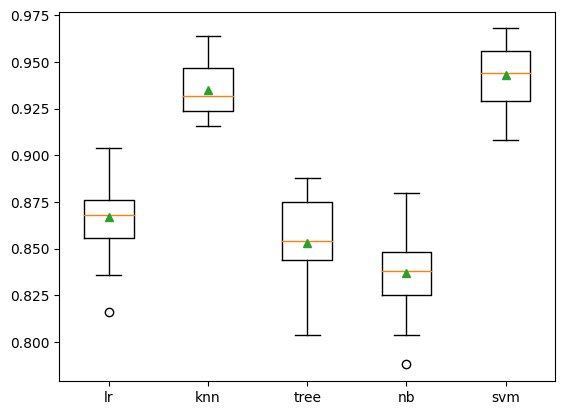

Mean Accuracy: 0.925 (0.016)


In [1]:
# evaluate standard models on the synthetic dataset
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from matplotlib import pyplot

# get the dataset
def get_dataset():
    X, y = make_classification(n_samples=2500, n_features=20, n_informative=10, n_redundant=10, random_state=1)
    return X, y

# get a list of models to evaluate
def get_models():
    models = list()
    models.append(('lr', LogisticRegression()))
    models.append(('knn', KNeighborsClassifier()))
    models.append(('tree', DecisionTreeClassifier()))
    models.append(('nb', GaussianNB()))
    models.append(('svm', SVC(probability=True)))
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the model evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate the model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models:
    # evaluate model
    scores = evaluate_model(model, X, y)
    # store results
    results.append(scores)
    names.append(name)
    # summarize result
    print('> %s %.3f (%.3f)' % (name, mean(scores), std(scores)))

# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

# create the ensemble
ensemble = VotingClassifier(estimators=models, voting='soft')
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the ensemble
scores = cross_val_score(ensemble, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize the result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))


In [3]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.ensemble import VotingClassifier
from numpy import mean

# evaluate a list of models
def evaluate_ensemble(models, X, y):
    # check for no models
    if len(models) == 0:
        return 0.0
    # create the ensemble
    ensemble = VotingClassifier(estimators=models, voting='soft')
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate the ensemble
    scores = cross_val_score(ensemble, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # return mean score
    return mean(scores)

# perform a single round of pruning the ensemble
def prune_round(models_in, X, y):
    # establish a baseline
    baseline = evaluate_ensemble(models_in, X, y)
    best_score, removed = baseline, None
    # enumerate removing each candidate and see if we can improve performance
    for m in models_in:
        # copy the list of chosen models
        dup = models_in.copy()
        # remove this model
        dup.remove(m)
        # evaluate new ensemble
        result = evaluate_ensemble(dup, X, y)
        # check for new best
        if result > best_score:
            # store the new best
            best_score, removed = result, m
    return best_score, removed

# prune an ensemble from scratch
def prune_ensemble(models, X, y):
    best_score = 0.0
    # prune ensemble until no further improvement
    while True:
        # remove one model from the ensemble
        score, removed = prune_round(models, X, y)
        # check for no improvement
        if removed is None:
            print('> no further improvement')
            break
        # keep track of the best score
        best_score = score
        # remove model from the list
        models.remove(removed)
        # report results along the way
        print('> %.3f (removed: %s)' % (score, removed[0]))
    return best_score, models

# prune the ensemble
score, model_list = prune_ensemble(models, X, y)
names = ','.join([n for n, _ in model_list])
print('Models: %s' % names)
print('Final Mean Accuracy: %.3f' % score)


> 0.933 (removed: nb)
> 0.940 (removed: tree)
> 0.945 (removed: lr)
> no further improvement
Models: knn,svm
Final Mean Accuracy: 0.945


In [5]:
# perform a single round of growing the ensemble
def grow_round(models_in, models_candidate, X, y):
    # establish a baseline
    baseline = evaluate_ensemble(models_in, X, y)
    best_score, addition = baseline, None
    # enumerate adding each candidate and see if we can improve performance
    for m in models_candidate:
        # copy the list of chosen models
        dup = models_in.copy()
        # add the candidate
        dup.append(m)
        # evaluate new ensemble
        result = evaluate_ensemble(dup, X, y)
        # check for new best
        if result > best_score:
            # store the new best
            best_score, addition = result, m
    return best_score, addition

# grow an ensemble from scratch
def grow_ensemble(models, X, y):
    best_score, best_list = 0.0, list()
    # grow ensemble until no further improvement
    while True:
        # add one model to the ensemble
        score, addition = grow_round(best_list, models, X, y)
        # check for no improvement
        if addition is None:
            print('>no further improvement')
            break
        # keep track of the best score
        best_score = score
        # remove the new model from the list of candidates
        models.remove(addition)
        # add the new model to the list of models in the ensemble
        best_list.append(addition)
        # report results along the way
        names = ','.join([n for n, _ in best_list])
        print('>%.3f (%s)' % (score, names))
    return best_score, best_list

# prune the ensemble
score, model_list = grow_ensemble(models, X, y)
names = ','.join([n for n, _ in model_list])
print('Models: %s' % names)
print('Final Mean Accuracy: %.3f' % score)


>0.943 (svm)
>0.945 (svm,knn)
>no further improvement
Models: svm,knn
Final Mean Accuracy: 0.945


### Task2:
Train and evaluate models as discussed in Section 2, 3, and 4 on Diabetes data set select the bestmodel based on evaluation scores.

> lr 0.773 (0.041)
> knn 0.717 (0.040)
> tree 0.698 (0.059)
> nb 0.759 (0.055)
> svm 0.757 (0.040)


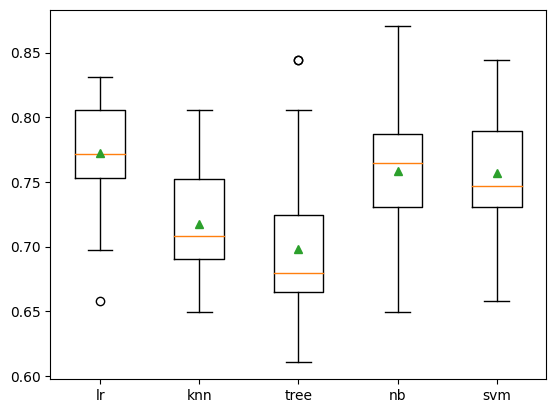

Mean Accuracy: 0.751 (0.051)


In [7]:
# evaluate standard models on the synthetic dataset
import pandas as pd
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from matplotlib import pyplot

# get the dataset
def get_dataset():
    data = pd.read_csv('diabetes.csv')
    X = data.drop(columns='Outcome')
    y = data['Outcome']
    return X, y

# get a list of models to evaluate
def get_models():
    models = list()
    models.append(('lr', LogisticRegression()))
    models.append(('knn', KNeighborsClassifier()))
    models.append(('tree', DecisionTreeClassifier()))
    models.append(('nb', GaussianNB()))
    models.append(('svm', SVC(probability=True)))
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the model evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate the model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# define dataset
X_db, y_db = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models:
    # evaluate model
    scores = evaluate_model(model, X_db, y_db)
    # store results
    results.append(scores)
    names.append(name)
    # summarize result
    print('> %s %.3f (%.3f)' % (name, mean(scores), std(scores)))

# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

# create the ensemble
ensemble = VotingClassifier(estimators=models, voting='soft')
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the ensemble
scores = cross_val_score(ensemble, X_db, y_db, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize the result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))


In [8]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.ensemble import VotingClassifier
from numpy import mean

# evaluate a list of models
def evaluate_ensemble(models, X, y):
    # check for no models
    if len(models) == 0:
        return 0.0
    # create the ensemble
    ensemble = VotingClassifier(estimators=models, voting='soft')
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate the ensemble
    scores = cross_val_score(ensemble, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # return mean score
    return mean(scores)

# perform a single round of pruning the ensemble
def prune_round(models_in, X, y):
    # establish a baseline
    baseline = evaluate_ensemble(models_in, X, y)
    best_score, removed = baseline, None
    # enumerate removing each candidate and see if we can improve performance
    for m in models_in:
        # copy the list of chosen models
        dup = models_in.copy()
        # remove this model
        dup.remove(m)
        # evaluate new ensemble
        result = evaluate_ensemble(dup, X, y)
        # check for new best
        if result > best_score:
            # store the new best
            best_score, removed = result, m
    return best_score, removed

# prune an ensemble from scratch
def prune_ensemble(models, X, y):
    best_score = 0.0
    # prune ensemble until no further improvement
    while True:
        # remove one model from the ensemble
        score, removed = prune_round(models, X, y)
        # check for no improvement
        if removed is None:
            print('> no further improvement')
            break
        # keep track of the best score
        best_score = score
        # remove model from the list
        models.remove(removed)
        # report results along the way
        print('> %.3f (removed: %s)' % (score, removed[0]))
    return best_score, models

# prune the ensemble
score, model_list = prune_ensemble(models, X_db, y_db)
names = ','.join([n for n, _ in model_list])
print('Models: %s' % names)
print('Final Mean Accuracy: %.3f' % score)


> 0.764 (removed: knn)
> 0.767 (removed: tree)
> 0.768 (removed: nb)
> 0.773 (removed: svm)
> no further improvement
Models: lr
Final Mean Accuracy: 0.773


In [9]:
# perform a single round of growing the ensemble
def grow_round(models_in, models_candidate, X, y):
    # establish a baseline
    baseline = evaluate_ensemble(models_in, X, y)
    best_score, addition = baseline, None
    # enumerate adding each candidate and see if we can improve performance
    for m in models_candidate:
        # copy the list of chosen models
        dup = models_in.copy()
        # add the candidate
        dup.append(m)
        # evaluate new ensemble
        result = evaluate_ensemble(dup, X, y)
        # check for new best
        if result > best_score:
            # store the new best
            best_score, addition = result, m
    return best_score, addition

# grow an ensemble from scratch
def grow_ensemble(models, X, y):
    best_score, best_list = 0.0, list()
    # grow ensemble until no further improvement
    while True:
        # add one model to the ensemble
        score, addition = grow_round(best_list, models, X, y)
        # check for no improvement
        if addition is None:
            print('>no further improvement')
            break
        # keep track of the best score
        best_score = score
        # remove the new model from the list of candidates
        models.remove(addition)
        # add the new model to the list of models in the ensemble
        best_list.append(addition)
        # report results along the way
        names = ','.join([n for n, _ in best_list])
        print('>%.3f (%s)' % (score, names))
    return best_score, best_list

# prune the ensemble
score, model_list = grow_ensemble(models, X_db, y_db)
names = ','.join([n for n, _ in model_list])
print('Models: %s' % names)
print('Final Mean Accuracy: %.3f' % score)


>0.773 (lr)
>no further improvement
Models: lr
Final Mean Accuracy: 0.773
